In [1]:
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py

import scipy.stats as ss
from sklearn.metrics import r2_score, average_precision_score, roc_auc_score

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../CODE/')
from importlib import reload
import visualization_utils
reload(visualization_utils)
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
## Gene name conversion for yeast
yeast_sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

## Gene name conversion for yeast
human_sys2com_dict = {
    row['#ensembl_gene_id']: row['external_gene_name'] \
    for _, row in pd.read_csv(
        '../RESOURCES/Human_genome/genes.protein_coding.BioMart.tbl', 
        sep='\t', usecols=[0, 1]
    ).iterrows()}

human_com2sys_dict = {
    row['external_gene_name']: row['#ensembl_gene_id'] \
    for _, row in pd.read_csv(
        '../RESOURCES/Human_genome/genes.protein_coding.BioMart.tbl', 
        sep='\t', usecols=[0, 1]
    ).iterrows()}

### Fig. 6A: The variance explained for predicting response frequency

In [9]:
stats_df = pd.DataFrame()

stats = pd.read_csv('../OUTPUT/Yeast_zev_defreq/tf_indep_feats/freq/stats.csv.gz')
stats_df = stats_df.append(pd.Series({
    'median': stats['r2'].median(), 
    'min': stats['r2'].min(), 
    'max': stats['r2'].max(),
    'organism': 'Yeast: TF pert'}), 
    ignore_index=True)

stats = pd.read_csv('../OUTPUT/Human_defreq_chipped_tfs/tf_indep_feats/freq/stats.csv.gz')
stats_df = stats_df.append(pd.Series({
    'median': stats['r2'].median(), 
    'min': stats['r2'].min(), 
    'max': stats['r2'].max(),
    'organism': 'Human: TF pert'}), 
    ignore_index=True)

stats = pd.read_csv('../OUTPUT/Human_defreq_all_pertbs/tf_indep_feats/freq/stats.csv.gz')
stats_df = stats_df.append(pd.Series({
    'median': stats['r2'].median(), 
    'min': stats['r2'].min(), 
    'max': stats['r2'].max(),
    'organism': 'Human: all pert'}), 
    ignore_index=True)

stats_df['organism'] = pd.Categorical(
    stats_df['organism'], ordered=True, 
    categories=['Yeast: TF pert', 'Human: TF pert', 'Human: all pert'])

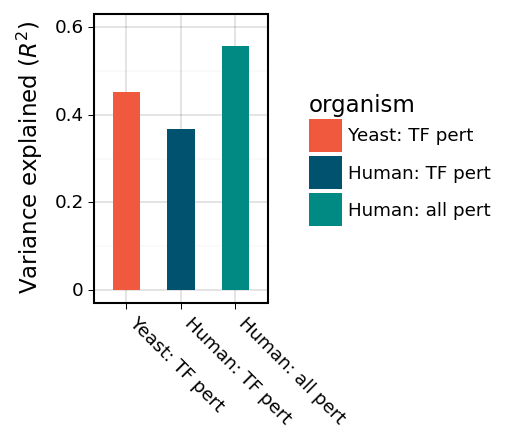

<ggplot: (7011028926)>

In [11]:
## Make barplots
ax = (
    ggplot(stats_df, aes(x='organism', y='median', fill='organism'))
    + geom_bar(stat='identity', alpha=1, width=.5)
#     + geom_errorbar(aes(ymin='min', ymax='max'), width=.15)
    + scale_fill_manual([COLORS['orange'], COLORS['dark_blue'], COLORS['dark_green']])
    + ylim(0, .6)
    + labs(x=None, y='Variance explained ($R^2$)')
    + theme_linedraw()
    + theme(
        figure_size=(1.5, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45, hjust=0),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 6B: The mean absolute influence of each yeast TF-independent feature on predicted response frequency

In [12]:
data_dir = '../OUTPUT/Yeast_zev_defreq/tf_indep_feats/freq'

shap_df = pd.read_csv('{}/feat_shap_wbg.csv.gz'.format(data_dir))
feats_df = pd.read_csv('{}/feats.csv.gz'.format(data_dir), names=['feat_type', 'feat_name', 'start', 'end'])
preds_df = pd.read_csv('{}/preds.csv.gz'.format(data_dir))

FEAT_DICT = {
    'gene_expression:median_level': 'GEX level',
    'gene_expression:variation': 'GEX var',
    'histone_modifications:h3k27ac_tp1_0_merged': 'H3K27ac',
    'histone_modifications:h3k36me3_tp1_0_merged': 'H3K36me3',
    'histone_modifications:h3k4me3_tp1_0_merged': 'H3K4me3',
    'histone_modifications:h3k4me_tp1_0_merged': 'H3K4me1',
    'histone_modifications:h3k79me_tp1_0_merged': 'H3K79me1',
    'histone_modifications:h4k16ac_tp1_0_merged': 'H4K16ac',
    'chromatin_accessibility:BY4741_ypd_osm_0min.occ': 'Chrom acc',
    'dna_sequence:nt_freq_agg': 'DNA sequence'}

feats_idx = pd.DataFrame()
for _, row in feats_df.iterrows():
    if row['feat_type'] == 'dna_sequence_nt_freq':
        type_name = 'dna_sequence:nt_freq_agg'
    else:
        type_name = row['feat_type'] + ':' + row['feat_name']
    type_name2 = FEAT_DICT[type_name]
    for i in range(row['start'], row['end']):
        feats_idx = feats_idx.append(pd.Series({'feat_type_name': type_name2, 'feat_idx': i}), ignore_index=True)

## Parse out shap+ and shap- values
shap_df = shap_df.rename(columns={'feat': 'shap'})
shap_df = shap_df.merge(preds_df[['gene', 'label']], how='left', on='gene')
shap_df['shap+'] = [x if x > 0 else 0 for x in shap_df['shap']]
shap_df['shap-'] = [x if x < 0 else 0 for x in shap_df['shap']]

## Sum across reg region for each feature and each gene, and then take 
## the mean among responsive targets and repeat for non-responsive targets.
shap_df = shap_df.merge(feats_idx[['feat_type_name', 'feat_idx']], on='feat_idx')
sum_shap = shap_df.groupby(['gene', 'feat_type_name'])[['shap+', 'shap-']].sum().reset_index()
sum_shap['abs_shap'] = np.abs(sum_shap['shap+']) + np.abs(sum_shap['shap-'])
sum_shap_comb = sum_shap.groupby(['feat_type_name'])['abs_shap'].mean().reset_index()
sum_shap_comb = sum_shap_comb.append(pd.DataFrame({
    'feat_type_name': ['H3K27me3', 'H3K9me3'], 'abs_shap': [None, None]
    }), ignore_index=True)

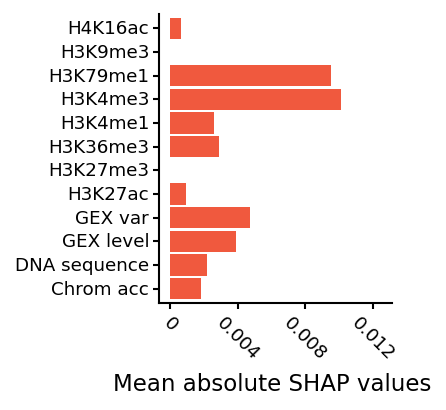

<ggplot: (-9223372029843889250)>

In [13]:
ax = (
    ggplot(sum_shap_comb, aes(x='feat_type_name', y='abs_shap'))
    + geom_bar(stat='identity', alpha=1, fill=COLORS['orange'])
    + coord_flip()
    + ylim(0, .0125)
    + labs(x=None, y='Mean absolute SHAP values')
    + theme_classic()
    + theme(
        figure_size=(2, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 6C: The mean absolute influence of each human TF-independent feature on predicted response frequency in TF perturbations

In [14]:
data_dir = '../OUTPUT/Human_defreq_chipped_tfs/tf_indep_feats/freq/'

shap_df = pd.read_csv('{}/feat_shap_wbg.csv.gz'.format(data_dir))
feats_df = pd.read_csv('{}/feats.csv.gz'.format(data_dir), names=['feat_type', 'feat_name', 'start', 'end'])
preds_df = pd.read_csv('{}/preds.csv.gz'.format(data_dir))

FEAT_DICT = {
    'gene_expression:median_level': 'GEX level',
    'gene_expression:variation': 'GEX var',
    'histone_modifications:K562_H3K27ac': 'H3K27ac',
    'histone_modifications:K562_H3K27me3': 'H3K27me3',
    'histone_modifications:K562_H3K36me3': 'H3K36me3',
    'histone_modifications:K562_H3K4me1': 'H3K4me1',
    'histone_modifications:K562_H3K4me3': 'H3K4me3',
    'histone_modifications:K562_H3K9me3': 'H3K9me3',
    'chromatin_accessibility:K562_atac': 'Chrom acc',
    'dna_sequence:nt_freq_agg': 'DNA sequence'}

feats_idx = pd.DataFrame()
for _, row in feats_df.iterrows():
    if row['feat_type'] == 'dna_sequence_nt_freq':
        type_name = 'dna_sequence:nt_freq_agg'
    else:
        type_name = row['feat_type'] + ':' + row['feat_name']
    type_name2 = FEAT_DICT[type_name]
    for i in range(row['start'], row['end']):
        feats_idx = feats_idx.append(pd.Series({'feat_type_name': type_name2, 'feat_idx': i}), ignore_index=True)

## Parse out shap+ and shap- values
shap_df = shap_df.rename(columns={'feat': 'shap'})
shap_df = shap_df.merge(preds_df[['gene', 'label']], how='left', on='gene')
shap_df['shap+'] = [x if x > 0 else 0 for x in shap_df['shap']]
shap_df['shap-'] = [x if x < 0 else 0 for x in shap_df['shap']]

## Sum across reg region for each feature and each gene, and then take 
## the mean among responsive targets and repeat for non-responsive targets.
shap_df = shap_df.merge(feats_idx[['feat_type_name', 'feat_idx']], on='feat_idx')
sum_shap = shap_df.groupby(['gene', 'feat_type_name'])[['shap+', 'shap-']].sum().reset_index()
sum_shap['abs_shap'] = np.abs(sum_shap['shap+']) + np.abs(sum_shap['shap-'])
sum_shap_comb = sum_shap.groupby(['feat_type_name'])['abs_shap'].mean().reset_index()
sum_shap_comb = sum_shap_comb.append(pd.DataFrame({
    'feat_type_name': ['H3K79me1', 'H4K16ac'], 'abs_shap': [None, None]
    }), ignore_index=True)

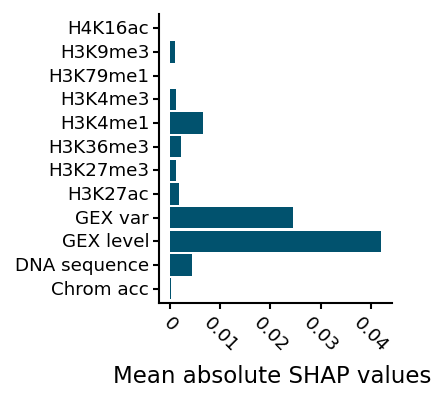

<ggplot: (-9223372029843517601)>

In [15]:
ax = (
    ggplot(sum_shap_comb, aes(x='feat_type_name', y='abs_shap'))
    + geom_bar(stat='identity', alpha=1, fill=COLORS['dark_blue'])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
    + theme_classic()
    + theme(
        figure_size=(2, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

### Fig. 6D: The mean absolute influence of each human TF-independent feature on predicted response frequency in all genetic perturbations

In [16]:
data_dir = '../OUTPUT/Human_defreq_all_pertbs/tf_indep_feats/freq/'

shap_df = pd.read_csv('{}/feat_shap_wbg.csv.gz'.format(data_dir))
feats_df = pd.read_csv('{}/feats.csv.gz'.format(data_dir), names=['feat_type', 'feat_name', 'start', 'end'])
preds_df = pd.read_csv('{}/preds.csv.gz'.format(data_dir))

FEAT_DICT = {
    'gene_expression:median_level': 'GEX level',
    'gene_expression:variation': 'GEX var',
    'histone_modifications:K562_H3K27ac': 'H3K27ac',
    'histone_modifications:K562_H3K27me3': 'H3K27me3',
    'histone_modifications:K562_H3K36me3': 'H3K36me3',
    'histone_modifications:K562_H3K4me1': 'H3K4me1',
    'histone_modifications:K562_H3K4me3': 'H3K4me3',
    'histone_modifications:K562_H3K9me3': 'H3K9me3',
    'chromatin_accessibility:K562_atac': 'Chrom acc',
    'dna_sequence:nt_freq_agg': 'DNA sequence'}

feats_idx = pd.DataFrame()
for _, row in feats_df.iterrows():
    if row['feat_type'] == 'dna_sequence_nt_freq':
        type_name = 'dna_sequence:nt_freq_agg'
    else:
        type_name = row['feat_type'] + ':' + row['feat_name']
    type_name2 = FEAT_DICT[type_name]
    for i in range(row['start'], row['end']):
        feats_idx = feats_idx.append(pd.Series({'feat_type_name': type_name2, 'feat_idx': i}), ignore_index=True)

## Parse out shap+ and shap- values
shap_df = shap_df.rename(columns={'feat': 'shap'})
shap_df = shap_df.merge(preds_df[['gene', 'label']], how='left', on='gene')
shap_df['shap+'] = [x if x > 0 else 0 for x in shap_df['shap']]
shap_df['shap-'] = [x if x < 0 else 0 for x in shap_df['shap']]

## Sum across reg region for each feature and each gene, and then take 
## the mean among responsive targets and repeat for non-responsive targets.
shap_df = shap_df.merge(feats_idx[['feat_type_name', 'feat_idx']], on='feat_idx')
sum_shap = shap_df.groupby(['gene', 'feat_type_name'])[['shap+', 'shap-']].sum().reset_index()
sum_shap['abs_shap'] = np.abs(sum_shap['shap+']) + np.abs(sum_shap['shap-'])
sum_shap_comb = sum_shap.groupby(['feat_type_name'])['abs_shap'].mean().reset_index()
sum_shap_comb = sum_shap_comb.append(pd.DataFrame({
    'feat_type_name': ['H3K79me1', 'H4K16ac'], 'abs_shap': [None, None]
    }), ignore_index=True)

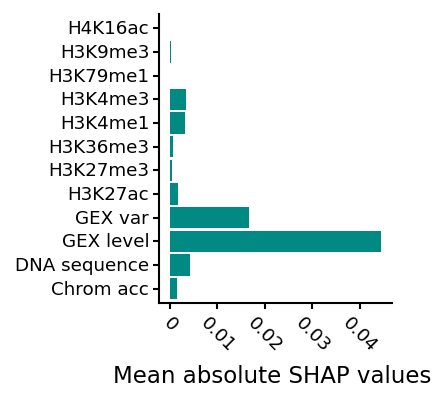

<ggplot: (7010886646)>

In [17]:
ax = (
    ggplot(sum_shap_comb, aes(x='feat_type_name', y='abs_shap'))
    + geom_bar(stat='identity', alpha=1, fill=COLORS['dark_green'])
    + coord_flip()
    + labs(x=None, y='Mean absolute SHAP values')
    + theme_classic()
    + theme(
        figure_size=(2, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)